In [7]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

wave_files = [
    "speech1.wav",
    "speech2.wav"
]

Matplotlib is building the font cache; this may take a moment.


**1 Fundamental frequency estimation by eye**

1a) Load the wave files from the archive. What is the sampling frequency of the signals?

In [8]:
def get_sampling_freq(path):
    _, sampling_rate = librosa.load(path)
    print(f"The sampling frequency of file '{path}' is {sampling_rate} Hz.")

for file in wave_files:
    get_sampling_freq(file)

The sampling frequency of file 'speech1.wav' is 22050 Hz.
The sampling frequency of file 'speech2.wav' is 22050 Hz.


b) Plot the signal as a function of time [s]. For this, create a vector which contains the time instants for each sample. For plotting, you can employ the plot command from matplotlib.pyplot

Identify the voiced, unvoiced and silence regions in the waveform. Which criteria did you use to
distinguish between the three signal types?

Filename: 'speech1.wav'
Sampling rate: 22050 Hz
Length: 2.8416326530612244 s


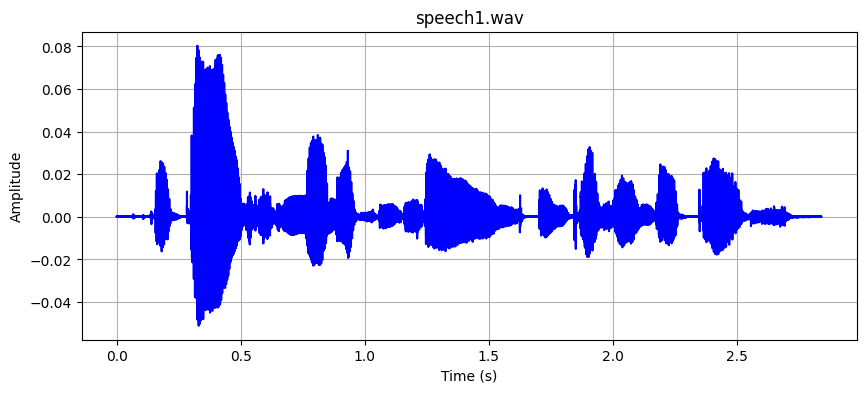

Filename: 'speech2.wav'
Sampling rate: 22050 Hz
Length: 2.860816326530612 s


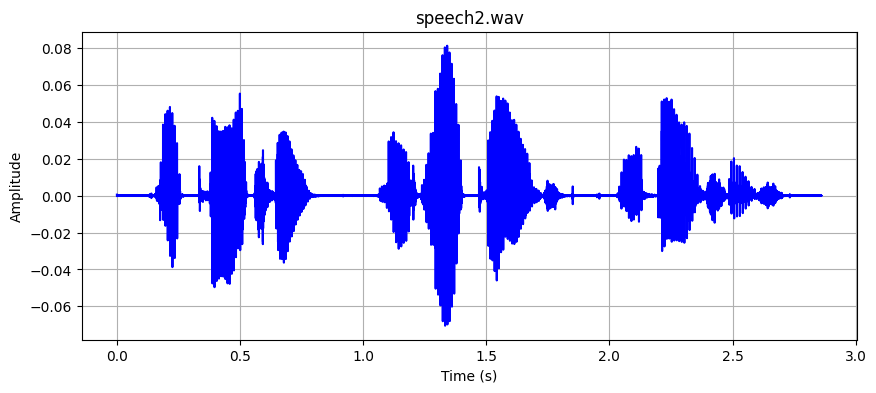

In [29]:
def plot_signal(path: str):
    print(f"Filename: '{path}'")
    y, sr = librosa.load(path)

    print(f"Sampling rate: {sr} Hz")
    print(f"Length: {len(y)/sr} s")

    # create a vector which contains the time instants for each sample
    time = np.arange(0, len(y)) / sr

    # create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, y, color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(path)
    plt.grid(True)
    plt.show()

plot_signal(wave_files[0])
plot_signal(wave_files[1])


c) Pick a single voiced segment from both signals and estimate the fundamental frequency from the waveform.
The results measured this way may be helpful to verify the outcomes of the fundamental frequency estimator
in part 3 of the exercise.

Plot your selected segments and describe your procedure. Judging based on the measured fundamental
frequencies, do the signals originate rather from a male or a female speaker? Verify your findings by
listening to the signals! (In the following exercises you should be able to listen to audio data contained
in numpy (abbreviated with np) arrays. For this you could use the play function from sounddevice.)

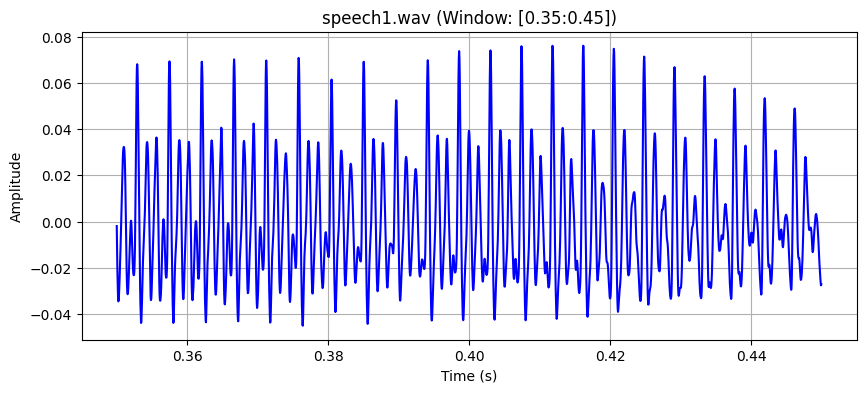

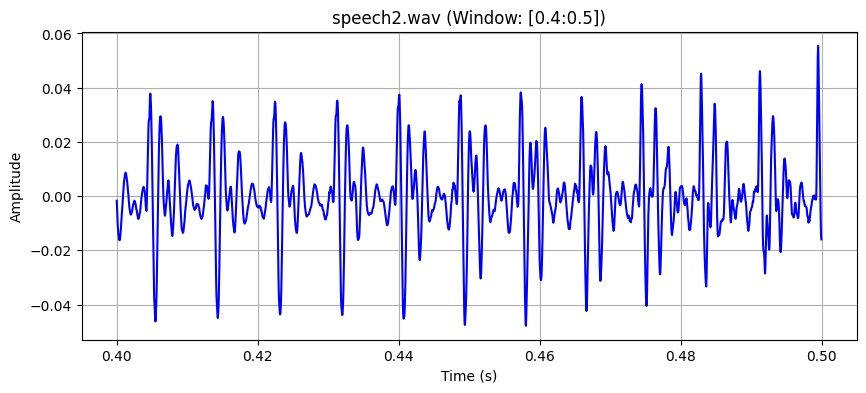

In [34]:
def plot_window(path, start, end):
    y, sr = librosa.load(path)

    # create a vector which contains the time instants for each sample
    y1 = int(start * sr)
    y2 = int(end * sr)

    time = np.arange(y1, y2) / sr

    # create the plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, y[y1:y2], color='b')
    plt.xlabel(f'Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f"{path} (Window: [{start}:{end}])")
    plt.grid(True)
    plt.show()

plot_window(wave_files[0], 0.35, 0.45)
plot_window(wave_files[1], 0.4, 0.5)

In [35]:

print(f"Window size: 0.02 s")
print(f"Plot 1: {4 * 50} Hz")
print(f"Plot 2: {2 * 50} Hz")

Plot 1: 200 Hz
Plot 2: 100 Hz


In [11]:


def my_windowing(v_signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int) -> (np.ndarray, np.ndarray):
    num_frames = int(np.ceil((len(v_signal) - frame_length + frame_shift) / frame_shift))
    m_frames = np.zeros((num_frames, frame_length))
    v_time_frame = np.zeros(num_frames)
    
    for i in range(num_frames):
        start_index = i * frame_shift
        end_index = min(start_index + frame_length, len(v_signal))
        frame = v_signal[start_index:end_index]
        m_frames[i, :len(frame)] = frame
        v_time_frame[i] = (start_index + end_index) / 2 / sampling_rate
    
    return m_frames, v_time_frame


# Example input signal (replace it with your own signal)
v_signal = np.random.rand(1000)

# Sample values for sampling rate, frame length, and frame shift
sampling_rate = 44100  # Assuming a sampling rate of 44.1 kHz
frame_length = 20  # Length of each frame in milliseconds
frame_shift = 10  # Shift between consecutive frames in milliseconds

# Call the function
m_frames, v_time_frame = my_windowing(v_signal, sampling_rate, frame_length, frame_shift)

# Print the shape of the output matrices
print("Shape of m_frames:", m_frames.shape)
print("Shape of v_time_frame:", v_time_frame.shape)


Shape of m_frames: (99, 20)
Shape of v_time_frame: (99,)
